In [1]:
import sys
sys.path.append('../../')
from search import search_local
import numpy as np
from tools.tools import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Define parammeters for dividing up Rz space into rectangular bins. All units in kpc.

In [2]:
R_max = 10.
R_min = 5.
z_max = 1.
z_min = -1.
R_pixel = 0.05
z_pixel = 0.005
bin_R = (R_max - R_min)/R_pixel
bin_z = (z_max - z_min)/z_pixel
epsilon = 0.5 # the radius around sun that we assume has most stars

In [3]:
print(bin_R)
print(bin_z)

100.0
400.0


Get gaia catalogue, convert from cartesian to cylindrical

In [4]:
samples = search_local.get_entire_catalogue()
x, y, z, vx, vy, vz = samples.T
cylcoord = rect_to_cyl(x, y, z, vx, vy, vz)
R = cylcoord[:, 0]
z = cylcoord[:, 3]

Get stars close to the sun: epsilon kpc around sun

In [5]:
sun_galactic = np.array([0, 0, 0, 0, 0, 0])
close_stars = search_local.search_phase_space(*sun_galactic, epsilon = epsilon, v_scale = 0)
x_close, y_close, z_close, vx_close, vy_close, vz_close = close_stars.T
cyl_close = rect_to_cyl(x_close, y_close, z_close, vx_close, vy_close, vz_close)
R_close = cyl_close[:, 0]
z_close = cyl_close[:, 3]

Plot 2d histogram of gaia catalogue

Text(0.5,1,'Density Plot of All Gaia Data')

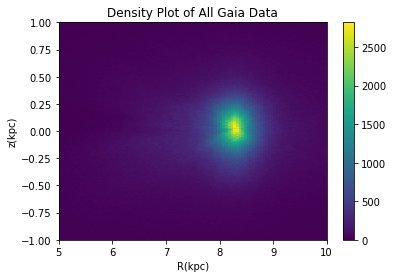

In [40]:
histogram, xedges, yedges, graph = plt.hist2d(R, z, bins = (bin_R, bin_z), range = [[R_min, R_max],[z_min, z_max]])
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Density Plot of All Gaia Data")

Define a function that get the gaia number density function from histogram result

In [7]:
def n_gaia(Rz):
    R = Rz[0]
    z = Rz[1]
    R_index = ((R-R_min)/R_pixel).astype(int)
    z_index = ((z-z_min)/z_pixel).astype(int)
    result = []
    for i in range(np.size(R_index)):
        result.append(histogram[R_index[i]][z_index[i]])
    return np.array(result)

Define the true number density function; scale length in unit of kpc

In [8]:
def n(Rz, n_0):
    R = Rz[0]
    z = Rz[1]
    return n_0*np.exp(-R/3 - np.abs(z)/0.3)

Curve fit the true number density function against gaia data in epsilon radius. Solve for the value of initial number density, and find the standard deviation of this value.

In [20]:
Rz = np.array([R_close, z_close])
np.shape(Rz)
popt, pcov = curve_fit(n, Rz, n_gaia(Rz))
n_0 = popt[0]
std_n_0 = pcov[0][0]
print("optimized n_0 =", n_0)
print("standard deviation of n_0 =", std_n_0)

Define a new, optimize theoretical density function that uses the optimize n_0, as well as being able to handle meshgrid

In [22]:
def n_optimized(R, z):
    return n_0*np.exp(-R/3 - np.abs(z)/0.3)

Graph the theoretical prediction of number density from the curve fit over entire space with Gaia data

Text(0.5,1,'Density plot of Theoretical Prediction')

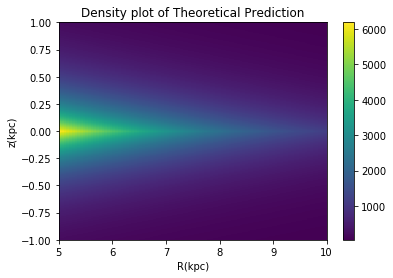

In [41]:
R_linspace = np.linspace(R_min, R_max, bin_R)
z_linspace = np.linspace(z_min, z_max, bin_z)
Rv, zv = np.meshgrid(R_linspace, z_linspace)
plt.pcolor(Rv, zv, n_optimized(Rv,zv))
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Density Plot of Theoretical Prediction")

Graph the theoretical prediction of number density from the curve fit over epsilon region of sun and compare with real number density

Text(0.5,0.98,'Comparison of Theoretical and Real Density in Epsilon Region')

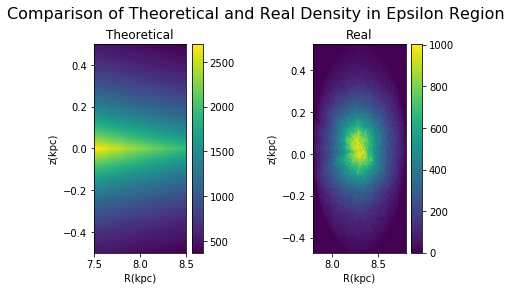

In [56]:
plt.figure(1)
plt.subplot(121)
R_linspace = np.linspace(8. - epsilon, 8.+epsilon, bin_R)
z_linspace = np.linspace(- epsilon, epsilon, bin_z)
Rv, zv = np.meshgrid(R_linspace, z_linspace)
plt.pcolor(Rv, zv, n_optimized(Rv,zv))
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Theoretical")

plt.subplot(122)
histogram, xedges, yedges, graph = plt.hist2d(R_close, z_close, bins = 100)
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Real")
plt.subplots_adjust(wspace=0.9, top = 0.85)
plt.suptitle('Comparison of Theoretical and Real Density in Epsilon Region', fontsize=16)